In [ ]:
from numpy.random import seed
seed(1914)
import tensorflow
tensorflow.random.set_seed(1918)

import numpy as np # linear algebra
import pandas as pd # data processing

import os
from sklearn.utils import compute_class_weight
import nltk
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import  utils
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import  utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPool1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, Dropout, MaxPooling1D, Input, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

stemmer = PorterStemmer()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
df_train.isna().sum()

Unnamed: 0    1
Text          1
Sentiment     4
dtype: int64

In [ ]:
df_test.isna().sum()

id      0
Text    0
dtype: int64

In [ ]:
df_train.head()

,Unnamed: 0,Text,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia: Woolworths to give elde...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive', nan], dtype=object)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41158 non-null  object
 1   Text        41158 non-null  object
 2   Sentiment   41155 non-null  object
dtypes: object(3)
memory usage: 964.8+ KB


Prepearing data:

*   drop missing values
*   delete STOP WORDS, lemmitization, stemming
*   convert to numeric






In [ ]:
# drop NaN
df_train.dropna(inplace=True)
df_train.reset_index(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41155 entries, 0 to 41154
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       41155 non-null  int64 
 1   Unnamed: 0  41155 non-null  object
 2   Text        41155 non-null  object
 3   Sentiment   41155 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [ ]:
# lemitization, stemming, deleting stop words
#url, lower,punct,stop,stem,lem
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def normalization(corpus):

  for i in range(len(corpus)): 
    # clean from url, punct., and lower all
    clean_text = re.sub(r"http\S+", "", corpus[i]) #url
    clean_text = re.sub(r'[^\w\s]', '', clean_text) #punct.
    clean_text = clean_text.lower() # lower

    tokens = word_tokenize(clean_text) # break line to words

    #Stop_words erase
    stop_words_cleaned = []  
    nltk_stop_words = set(stopwords.words("english"))
    for word in tokens:  
      if word not in nltk_stop_words:  
        stop_words_cleaned.append(word)
  
    #Stemming
    stemed_tokens = []
    for word in stop_words_cleaned:
      stemed_tokens.append(stemmer.stem(word))

    #Lemmatization
    lemmitized_text = []
    for word in stemed_tokens:
      lemmitized_text.append(lemmatizer.lemmatize(word)) 

    #return
    corpus[i] = lemmitized_text
      
normalization(df_train['Text'])
normalization(df_test['Text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_train.head()

,index,Unnamed: 0,Text,Sentiment
0,0,0,"[menyrbi, phil_gahan, chrisitv]",Neutral
1,1,1,"[advic, talk, neighbour, famili, exchang, phon...",Positive
2,2,2,"[coronaviru, australia, woolworth, give, elder...",Positive
3,3,3,"[food, stock, one, empti, plea, dont, panic, e...",Positive
4,4,4,"[readi, go, supermarket, covid19, outbreak, im...",Extremely Negative


In [ ]:
df_test.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,"[trend, new, yorker, encount, empti, supermark..."
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,"[couldnt, find, hand, sanit, fred, meyer, turn..."
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,"[find, protect, love, one, coronaviru]"
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,"[panic, buy, hit, newyork, citi, anxiou, shopp..."
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,"[toiletpap, dunnypap, coronaviru, coronavirusa..."


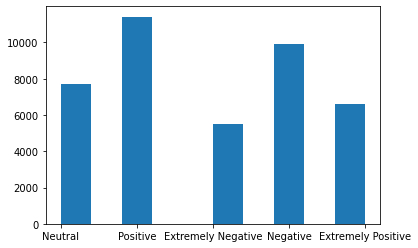

In [ ]:
# histogram of sentiment spreading
plt.hist(df_train['Sentiment'])
plt.show() 

look's like class disproportion

In [ ]:
# tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Text'].values)

# convert texts to numeric with one lenght
train_tokens = tokenizer.texts_to_sequences(df_train['Text'].values)
text_len=[]
for i in range(len(train_tokens)):
  text_len.append(len(train_tokens[i]))
max_text_len = max(text_len)
x_train = pad_sequences(train_tokens, maxlen= max_text_len)

test_tokens = tokenizer.texts_to_sequences(df_test['Text'].values)
x_test = pad_sequences(test_tokens, maxlen= max_text_len)

# encode sentiments
ohe = OneHotEncoder()
y_train = ohe.fit_transform(df_train[['Sentiment']].values)
y_train = y_train.toarray()

Finally models!

Gonna try three different:
*   CNN
*   LSTM
*   GRU


In [ ]:

print(x_train.shape, y_train.shape)

(41155, 46) (41155, 5)


In [ ]:
# max words count
num_words= 100000
# Sentient count
sentiment_count = 5 
# text lenght
text_len = len(x_train[0])
# compute classes weights
y_train_labels = df_train['Sentiment'].values
class_weights= compute_class_weight(
                                   class_weight = 'balanced',
                                   classes = np.unique(y_train_labels),
                                   y = y_train_labels)
classes = dict(zip(np.unique(y_train_labels), class_weights))
class_weights= {i : class_weights[i] for i in range(5)}
classes

{'Extremely Negative': 1.50173326035395,
 'Extremely Positive': 1.242602657004831,
 'Negative': 0.8299889079358677,
 'Neutral': 1.0674361302036053,
 'Positive': 0.7206268604447558}

In [ ]:
# CNN
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 46, input_length=text_len))
model_cnn.add(Conv1D(128, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(5, activation='softmax'))

In [ ]:
model_cnn.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# print model description
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 46, 46)            4600000   
                                                                 
 conv1d_4 (Conv1D)           (None, 42, 128)           29568     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                     

In [ ]:
#save best result
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path,
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [ ]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=256,
                            class_weight=class_weights,
                            validation_split=0.2)

Epoch 1/5
129/129 [==============================] - 12s 85ms/step - loss: 1.4489 - accuracy: 0.3251 - val_loss: 1.1962 - val_accuracy: 0.5411
Epoch 2/5
129/129 [==============================] - 13s 99ms/step - loss: 1.0771 - accuracy: 0.5093 - val_loss: 0.9639 - val_accuracy: 0.6107
Epoch 3/5
129/129 [==============================] - 11s 83ms/step - loss: 0.9227 - accuracy: 0.5983 - val_loss: 0.9016 - val_accuracy: 0.6477
Epoch 4/5
129/129 [==============================] - 11s 84ms/step - loss: 0.8311 - accuracy: 0.6525 - val_loss: 0.8709 - val_accuracy: 0.6669
Epoch 5/5
129/129 [==============================] - 11s 84ms/step - loss: 0.7565 - accuracy: 0.6900 - val_loss: 0.8639 - val_accuracy: 0.6625


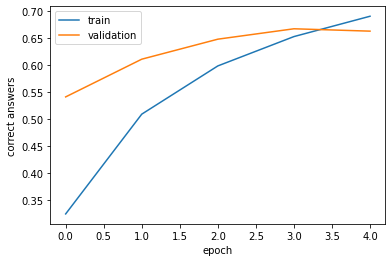

In [ ]:
# plot CNN
plt.plot(history_cnn.history['accuracy'],
         label='train')
plt.plot(history_cnn.history['val_accuracy'],
         label='validation')
plt.xlabel('epoch')
plt.ylabel('correct answers')
plt.legend()
plt.show()

In [ ]:
#LSTM
model_lstm=Sequential()
model_lstm.add(Embedding(num_words,32,input_length=text_len))
model_lstm.add(LSTM(150))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(5,activation='softmax'))

In [ ]:
model_lstm.compile(optimizer='Adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 46, 32)            3200000   
                                                                 
 lstm_6 (LSTM)               (None, 150)               109800    
                                                                 
 dropout_9 (Dropout)         (None, 150)               0         
                                                                 
 dense_14 (Dense)            (None, 5)                 755       
                                                                 
Total params: 3,310,555
Trainable params: 3,310,555
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(x_train,
                            y_train,
                            epochs=2,
                            batch_size=128,
                            class_weight=class_weights,
                            validation_split=0.2,
                            )

Epoch 1/2
258/258 [==============================] - 71s 265ms/step - loss: 1.3154 - accuracy: 0.3781 - val_loss: 1.0176 - val_accuracy: 0.5958
Epoch 2/2
258/258 [==============================] - 65s 254ms/step - loss: 0.7895 - accuracy: 0.6678 - val_loss: 0.8771 - val_accuracy: 0.6630


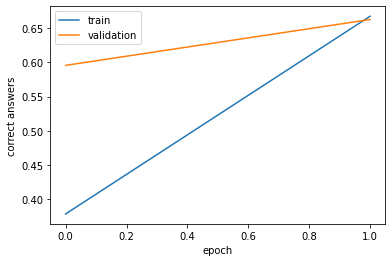

In [ ]:
# plot LSTM
plt.plot(history_lstm.history['accuracy'],
         label='train')
plt.plot(history_lstm.history['val_accuracy'],
         label='validation')
plt.xlabel('epoch')
plt.ylabel('correct answers')
plt.legend()
plt.show()

In [ ]:
#GRU
model_gru= Sequential()
model_gru.add(Embedding(num_words, 46, input_length=text_len))
model_gru.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_gru.add(MaxPooling1D(pool_size=2))
model_gru.add(GRU(128, dropout=.2, recurrent_dropout=.2))
model_gru.add(Dense(5, activation='softmax'))

In [ ]:
model_gru.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
model_gru.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 46, 46)            4600000   
                                                                 
 conv1d_5 (Conv1D)           (None, 46, 32)            4448      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 23, 32)           0         
 1D)                                                             
                                                                 
 gru_2 (GRU)                 (None, 128)               62208     
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 4,667,301
Trainable params: 4,667,301
Non-trainable params: 0
___________________________________________

In [ ]:
history_gru = model_gru.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=256,
                            class_weight=class_weights,
                            validation_split=0.2)

Epoch 1/5
129/129 [==============================] - 33s 225ms/step - loss: 1.4220 - accuracy: 0.3234 - val_loss: 1.1575 - val_accuracy: 0.4829
Epoch 2/5
129/129 [==============================] - 31s 239ms/step - loss: 0.9232 - accuracy: 0.5969 - val_loss: 0.8878 - val_accuracy: 0.6461
Epoch 3/5
129/129 [==============================] - 29s 224ms/step - loss: 0.7387 - accuracy: 0.7022 - val_loss: 0.8663 - val_accuracy: 0.6616
Epoch 4/5
129/129 [==============================] - 33s 258ms/step - loss: 0.6348 - accuracy: 0.7515 - val_loss: 0.8638 - val_accuracy: 0.6774
Epoch 5/5
129/129 [==============================] - 29s 222ms/step - loss: 0.5668 - accuracy: 0.7836 - val_loss: 0.9320 - val_accuracy: 0.6497


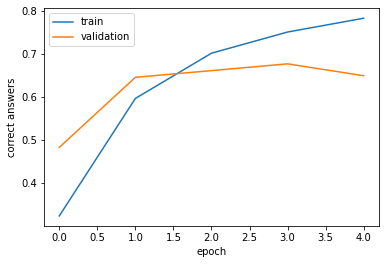

In [ ]:
# plot GRU
plt.plot(history_gru.history['accuracy'],
         label='train')
plt.plot(history_gru.history['val_accuracy'],
         label='validation')
plt.xlabel('epoch')
plt.ylabel('correct answers')
plt.legend()
plt.show()

Not the best results, but now I ran out all ideas.
Now I am fully opened for advices:)

In [ ]:
pred_test = model_cnn.predict(x_test)

119/119 [==============================] - 1s 5ms/step


In [ ]:
# make ohe matrix to get predictions
index = np.argmax(pred_test, axis=1) # get index
pred_matrix = np.zeros_like(pred_test) # 0 matrix

pred_matrix[np.arange(len(index)), index.T] = 1 # fill 1 by index

In [ ]:
ohe.inverse_transform(pred_matrix)

array([['Negative'],
       ['Extremely Positive'],
       ['Extremely Positive'],
       ...,
       ['Neutral'],
       ['Extremely Negative'],
       ['Extremely Positive']], dtype=object)

In [ ]:
sample_submission['Sentiment'] = ohe.inverse_transform(pred_matrix)

In [ ]:
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Extremely Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [ ]:
sample_submission.to_csv('submission.csv', index=False)

# Want to try Elmo
https://github.com/strongio/keras-elmo/blob/master/Elmo%20Keras.ipynb
